# Student Performance Microbenchmark
Simple statistical queries about students in a Portuguese class.
This file is adapted to use numpy only without Spark.

In [1]:
EXPERIMENT = 'pac-student_performance-sparkless'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = False

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

GENERATE = False, so we will load saved output from files rather than recomputing.


### Running PAC

In [2]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator

In [3]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [4]:
### Data Setup
por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
por_df.shape

(649, 33)

In [5]:
por_df['absences'].count()

649

In [6]:
true_result = por_df['absences'].agg(['count', 'sum', 'mean']).to_numpy()
true_result

array([ 649.        , 2375.        ,    3.65947612])

In [7]:
### Query Setup
SAMPLES = 512
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

true_result = por_df['absences'].agg(['count', 'sum', 'mean']).to_numpy() # Save the true result of the query for later
number_of_contributing_rows = por_df['absences'].count()

def rowwise_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select half of the row indices from the dataframe at random.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    indices = np.random.choice(df.index, size=(df.shape[0] // 2), replace=False)
    not_indices = list(set(df.index) - set(indices))
    selected: DataFrame = df.iloc[indices]
    not_selected: DataFrame = df.iloc[not_indices]
    return (selected, not_selected)

def run_query(i: int) -> List[np.ndarray]:
    # i is not used for anything, just to satisfy the map function.
    # Returns two results each invocation as a result of paired sampling.
    results = []
    for temp_df in rowwise_paired_sample(por_df):
        out_df = temp_df['absences'].agg(['count', 'mean'])  # run the query
        #out_df['count'] *= 2  # correct query result for the 50% subsampling
        #out_df['sum'] *= 2  # correct query result for the 50% subsampling
        results.append(out_df.to_numpy())
    return results

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # thresholding happens here for PAC -- if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)
    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        out_np.append(run_query(i))
    out_np = reduce(operator.iconcat, out_np, [])
    # https://stackoverflow.com/a/45323085

    #with concurrent.futures.ThreadPoolExecutor() as executor:
    #    out_np: List[np.ndarray] = list(executor.map(run_query, range(number_of_pairs)))
    #    out_np = reduce(operator.iconcat, out_np, [])
    #    # https://stackoverflow.com/a/45323085

    return out_np

In [8]:
s = generate_samples()
s

[array([324.        ,   3.81790123]),
 array([325.        ,   3.50153846]),
 array([324.       ,   3.5462963]),
 array([325.        ,   3.77230769]),
 array([324.        ,   3.58333333]),
 array([325.        ,   3.73538462]),
 array([324.        ,   3.68209877]),
 array([325.        ,   3.63692308]),
 array([324.  ,   3.75]),
 array([325.        ,   3.56923077]),
 array([324.        ,   3.87037037]),
 array([325.        ,   3.44923077]),
 array([324.        ,   3.65123457]),
 array([325.        ,   3.66769231]),
 array([324.        ,   3.80246914]),
 array([325.        ,   3.51692308]),
 array([324.        ,   3.92901235]),
 array([325.        ,   3.39076923]),
 array([324.       ,   3.5308642]),
 array([325.        ,   3.78769231]),
 array([324.        ,   3.66666667]),
 array([325.        ,   3.65230769]),
 array([324.        ,   3.45987654]),
 array([325.        ,   3.85846154]),
 array([324.        ,   3.63580247]),
 array([325.        ,   3.68307692]),
 array([324.        ,   3.60

In [9]:
# plot s[1] for all in list
#pd.DataFrame(s, columns=['count', 'mean']).hist("sum")

In [10]:
#pd.DataFrame(s, columns=['count', 'mean'])['sum']

In [11]:
# compute variance of pd.DataFrame(s, columns=['count', 'mean'])['sum']
#np.var(pd.DataFrame(s, columns=['count', 'mean'])['sum'])

In [12]:
### Compute PAC Noise
def updateDataFrame(vec: np.ndarray, df: DataFrame) -> DataFrame:
    """
    Update a DataFrame with a noisy output vector.
    """
    noisy_output_df = df.copy()
    noisy_output_df.loc[0] = vec
    return noisy_output_df

saved_pac_variables = []
# (out_np[0], fin_var, sqrt_total_var, pac_noise, pac_noises_to_add, pac_release)

def do_pac_and_release(out_np: List[np.ndarray],
                       max_mi: float = 1./4) -> np.ndarray:

    
    dimensions: int = len(out_np[0])

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, SAMPLES)

    # get the variance in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # variance of the PAC noise
    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)
    # Add noise element-wise to the outputs
    pac_release = out_np[0] + pac_noises_to_add

    saved_pac_variables.append((out_np[0], fin_var, sqrt_total_var, pac_noise, pac_noises_to_add, pac_release))
    
    return pac_release

# Update the DataFrame with the noisy output
# noisy_output_df = updateDataFrame(pac_release, out[0])

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [13]:
MI_OPTIONS = [16., 4., 2., 1., 1/4, 1/16, 1/32, 1/64]
EXPERIMENTS = 100

if GENERATE:
    # df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
    experiment_results = []

    for mi in MI_OPTIONS: 
        for e in range(EXPERIMENTS):
            out_np = generate_samples()
            noisy_output = do_pac_and_release(out_np, mi)
            # manually correct count = count * 2
            noisy_output[0] = noisy_output[0] * 2
            # manually add sum as count * mean
            noisy_output = [noisy_output[0], noisy_output[0] * noisy_output[1], noisy_output[1]]
            # try x2 here ?
            experiment_results.append([mi, *noisy_output])
        with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
            pickle.dump(experiment_results, f)
    
    df = pd.DataFrame(experiment_results, columns=['mi', 'count', 'sum', 'mean'])
    
    # Save the new data to outputs/...
    df.to_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    # with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
    #     pickle.dump(experiment_results, f)
else:
    df = pq.read_table(f"{OUTPUT_DIR}/pac_results.parquet").to_pandas()

    # with open('{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
    #     experiment_results = pickle.load(f)

df.head()

,mi,count,sum,mean
0,16.0,648.001141,2371.823291,3.660215
1,16.0,648.013605,2821.859766,4.354630
2,16.0,647.991999,2465.724509,3.805177
3,16.0,647.978332,2352.096180,3.629899
4,16.0,648.024163,2272.642177,3.507033


In [14]:
### DEBUG: Save the variables from computing the PAC noises for later reverse engineering
if GENERATE:
    saved_pac_variables_df = pd.DataFrame(saved_pac_variables, columns=['out_np_0', 'fin_var', 'sqrt_total_var', 'pac_noise', 'pac_noises_to_add', 'pac_release'])
    saved_pac_variables_df.to_parquet(f'{OUTPUT_DIR}/saved_pac_variables.parquet')
    saved_pac_variables_df.head()
else:
    saved_pac_variables_df = pq.read_table(f"{OUTPUT_DIR}/saved_pac_variables.parquet").to_pandas()
    saved_pac_variables_df.head()

### Computing PAC Errors

In [15]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [16]:
OUTPUT_COLS = ['count', 'sum', 'mean']
ERROR_COLS = [*[f'absolute error {i}' for i in OUTPUT_COLS], *[f'relative error {i}' for i in OUTPUT_COLS]]

In [17]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,16.000000,0.998859,3.176709,0.000739,0.153907,0.133756,0.020182
1,16.000000,0.986395,446.859766,0.695154,0.151987,18.815148,18.996006
2,16.000000,1.008001,90.724509,0.145701,0.155316,3.819979,3.981479
3,16.000000,1.021668,22.903820,0.029577,0.157422,0.964371,0.808222
4,16.000000,0.975837,102.357823,0.152443,0.150360,4.309803,4.165706
...,...,...,...,...,...,...,...
795,0.015625,16.135001,404.355953,0.732228,2.486133,17.025514,20.009099
796,0.015625,42.483776,3659.955869,5.778061,6.546036,154.103405,157.893109
797,0.015625,24.768439,143.470514,0.375037,3.816400,6.040864,10.248384
798,0.015625,0.033173,1904.294260,2.934535,0.005111,80.180811,80.190021


In [18]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Computing DP Errors

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [19]:
# Import Chai's saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"outputs/dp_results.parquet").to_pandas()

# compute sum from count and mean
dp_results_df['sum'] = dp_results_df['count'] * dp_results_df['mean']
dp_results_df = dp_results_df[['mi', 'count', 'sum', 'mean']]

dp_results_df

,mi,count,sum,mean
0,0.003906,628.537455,2429.761169,3.865738
1,0.003906,645.870327,2043.327919,3.163681
2,0.003906,653.086266,2665.629161,4.081588
3,0.003906,646.770900,2432.331776,3.760732
4,0.003906,642.851307,2246.435064,3.494486
...,...,...,...,...
895,16.000000,648.999477,2374.755286,3.659102
896,16.000000,648.727144,2372.603137,3.657321
897,16.000000,649.384486,2380.617120,3.665959
898,16.000000,649.058371,2373.732448,3.657194


In [20]:
# compute errors for DP (or import from saved file)
GENERATE_DP = True
if GENERATE_DP:
    errors_list = []
    for i, row in dp_results_df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    dp_errors_df.to_parquet(f"outputs/dp_errors.parquet")  # overwrite saved
else:
    dp_errors_df = pq.read_table(f"outputs/dp_errors.parquet").to_pandas()
dp_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,0.003906,20.462545,54.761169,0.206262,3.152934,2.305733,5.636379
1,0.003906,3.129673,331.672081,0.495795,0.482230,13.965140,13.548244
2,0.003906,4.086266,290.629161,0.422112,0.629625,12.237017,11.534767
3,0.003906,2.229100,57.331776,0.101256,0.343467,2.413970,2.766940
4,0.003906,6.148693,128.564936,0.164990,0.947410,5.413260,4.508565
...,...,...,...,...,...,...,...
895,16.000000,0.000523,0.244714,0.000374,0.000081,0.010304,0.010223
896,16.000000,0.272856,2.396863,0.002156,0.042043,0.100921,0.058903
897,16.000000,0.384486,5.617120,0.006483,0.059243,0.236510,0.177163
898,16.000000,0.058371,1.267552,0.002282,0.008994,0.053371,0.062359


In [21]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}),
    dp_results_df.assign(type='dp').rename(columns={'mi': 'factor'}),
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
#all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")  # Save the merged results
all_df

count mean   count var     sum mean       sum var  mean mean  \
type factor                                                                    
dp   0.003906   648.923386   77.840084  2377.304244  6.349945e+04   3.662953   
     0.007812   649.961611   40.165420  2382.420727  2.939317e+04   3.665351   
     0.015625   648.393822   13.409362  2369.303647  1.708593e+04   3.654258   
     0.062500   648.913733    2.660988  2376.192846  4.878789e+03   3.661818   
     0.250000   649.017877    0.812941  2377.840447  8.522155e+02   3.663748   
     1.000000   648.986612    0.023099  2375.351051  1.512266e+01   3.660092   
     2.000000   648.972047    0.021090  2376.132843  1.877518e+01   3.661379   
     4.000000   648.988489    0.014623  2375.143870  1.113865e+01   3.659763   
     16.000000  648.987634    0.016579  2375.403649  1.984399e+01   3.660168   
pac  0.015625   649.665941  461.322562  2722.308172  5.001556e+06   4.176623   
     0.031250   647.974268  109.028625  2419.654685  1.445629e+06   3.736373   
     0.062500   648.090407   33.794211  2375.192248  4.938061e+05   3.664144   
     0.250000   648.090562    1.687420  2362.413914  5.076660e+04   3.645136   
     1.000000   648.009955    0.098239  2395.649027  1.817912e+04   3.696914   
     2.000000   648.004490    0.037046  2382.589022  1.225427e+04   3.676816   
     4.000000   647.998574    0.006281  2390.071657  1.827163e+04   3.688394   
     16.000000  647.999847    0.000487  2370.624059  1.645520e+04   3.658370   

                 mean var  
type factor                
dp   0.003906    0.143685  
     0.007812    0.067374  
     0.015625    0.041348  
     0.062500    0.011637  
     0.250000    0.001968  
     1.000000    0.000034  
     2.000000    0.000044  
     4.000000    0.000025  
     16.000000   0.000047  
pac  0.015625   11.924480  
     0.031250    3.486065  
     0.062500    1.170490  
     0.250000    0.120320  
     1.000000    0.043141  
     2.000000    0.029224  
     4.000000    0.043538  
     16.000000   0.039181

In [22]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), 
    dp_errors_df.assign(type='dp').rename(columns={'mi': 'factor'}),
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error mean', 'mean'), ('relative error count', 'var'), ('relative error mean', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns

#errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error count var  absolute error sum mean  \
type factor                                                         
dp   0.003906                  38.859552               187.394666   
     0.007812                  19.091668               123.297923   
     0.015625                   6.407849                89.710428   
     0.062500                   1.263307                47.855712   
     0.250000                   0.377854                18.631552   
     1.000000                   0.015179                 2.893023   
     2.000000                   0.010542                 3.306416   
     4.000000                   0.006073                 2.538512   
     16.000000                  0.009055                 3.168717   
pac  0.015625                 154.181866              1782.337117   
     0.031250                  33.939446               897.643145   
     0.062500                   9.939363               554.299176   
     0.250000                   0.879657               183.829672   
     1.000000                   0.098239               105.456301   
     2.000000                   0.037046                90.554287   
     4.000000                   0.006281               105.215106   
     16.000000                  0.000487                99.266828   

                absolute error sum var  absolute error mean var  \
type factor                                                       
dp   0.003906             2.803333e+04                 0.065528   
     0.007812             1.409286e+04                 0.032633   
     0.015625             8.989449e+03                 0.023037   
     0.062500             2.566924e+03                 0.006270   
     0.250000             5.097240e+02                 0.001186   
     1.000000             6.793018e+00                 0.000015   
     2.000000             9.028662e+00                 0.000022   
     4.000000             4.650428e+00                 0.000010   
     16.000000            9.866375e+00                 0.000024   
pac  0.015625             1.914584e+06                 4.631490   
     0.031250             6.337412e+05                 1.555569   
     0.062500             1.834550e+05                 0.432827   
     0.250000             1.679191e+04                 0.040043   
     1.000000             7.376448e+03                 0.017949   
     2.000000             4.029537e+03                 0.009753   
     4.000000             7.319041e+03                 0.017510   
     16.000000            6.521105e+03                 0.015446   

                relative error count mean  relative error sum mean  \
type factor                                                          
dp   0.003906                    0.957260                 7.890302   
     0.007812                    0.719219                 5.191491   
     0.015625                    0.416280                 3.777281   
     0.062500                    0.181736                 2.014977   
     0.250000                    0.101163                 0.784486   
     1.000000                    0.013799                 0.121811   
     2.000000                    0.016325                 0.139218   
     4.000000                    0.014287                 0.106885   
     16.000000                   0.013434                 0.133420   
pac  0.015625                    2.688797                75.045773   
     0.031250                    1.337868                37.795501   
     0.062500                    0.761796                23.338913   
     0.250000                    0.196525                 7.740197   
     1.000000                    0.152549                 4.440265   
     2.000000                    0.153391                 3.812812   
     4.000000                    0.154303                 4.430110   
     16.000000                   0.154107                 4.179656   

                relative error sum var  relative error mean mean  
type factor                     

In [23]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [24]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [25]:
import matplotlib.colors as mcolors

PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# Function to lighten a color by blending with white
def lighten_color(color, amount=0.3):
    rgba = mcolors.to_rgba(color)
    return tuple(np.clip(np.array(rgba[:3]) + amount, 0, 1)) + (rgba[3],)

# Create lighter colors
PAC_LIGHT = lighten_color(PAC_COLOR, 0.3)
DP_LIGHT = lighten_color(DP_COLOR, 0.3)

# create legend, use color squares
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

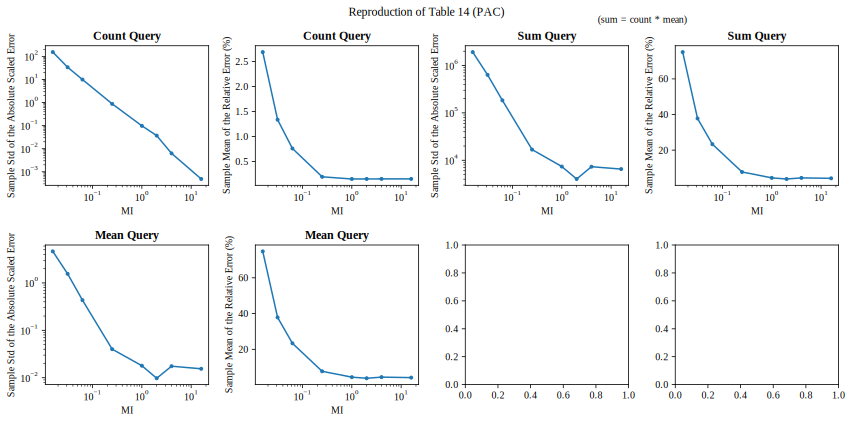

In [26]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.95, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

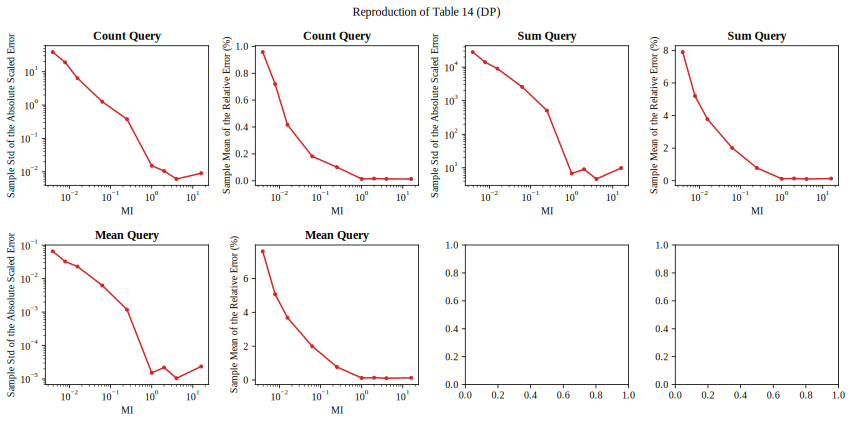

In [27]:
### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

An attempt at putting both on the same axes, not aligned

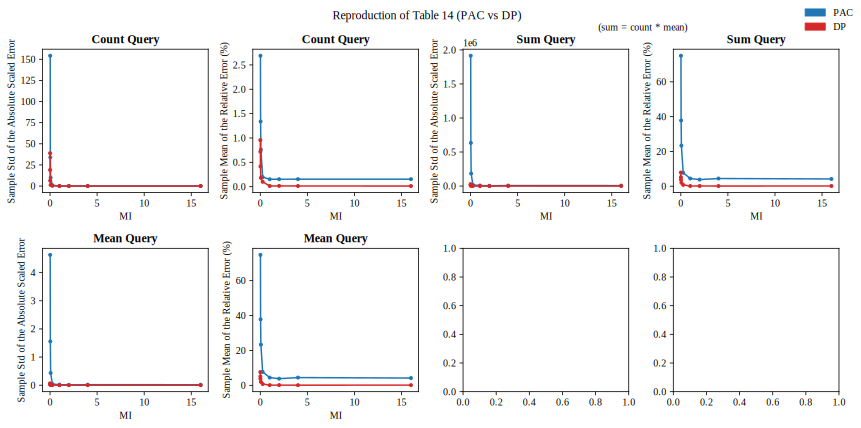

In [28]:
### An attempt at putting errors of both on the same axes, not aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    #print(d)
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')
    ax1.set_xlabel('MI')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')
    ax2.set_xlabel('MI')

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

In [33]:
pac_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,16.000000,0.998859,3.176709,0.000739,0.153907,0.133756,0.020182
1,16.000000,0.986395,446.859766,0.695154,0.151987,18.815148,18.996006
2,16.000000,1.008001,90.724509,0.145701,0.155316,3.819979,3.981479
3,16.000000,1.021668,22.903820,0.029577,0.157422,0.964371,0.808222
4,16.000000,0.975837,102.357823,0.152443,0.150360,4.309803,4.165706
...,...,...,...,...,...,...,...
795,0.015625,16.135001,404.355953,0.732228,2.486133,17.025514,20.009099
796,0.015625,42.483776,3659.955869,5.778061,6.546036,154.103405,157.893109
797,0.015625,24.768439,143.470514,0.375037,3.816400,6.040864,10.248384
798,0.015625,0.033173,1904.294260,2.934535,0.005111,80.180811,80.190021


In [34]:
dp_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,0.003906,20.462545,54.761169,0.206262,3.152934,2.305733,5.636379
1,0.003906,3.129673,331.672081,0.495795,0.482230,13.965140,13.548244
2,0.003906,4.086266,290.629161,0.422112,0.629625,12.237017,11.534767
3,0.003906,2.229100,57.331776,0.101256,0.343467,2.413970,2.766940
4,0.003906,6.148693,128.564936,0.164990,0.947410,5.413260,4.508565
...,...,...,...,...,...,...,...
895,16.000000,0.000523,0.244714,0.000374,0.000081,0.010304,0.010223
896,16.000000,0.272856,2.396863,0.002156,0.042043,0.100921,0.058903
897,16.000000,0.384486,5.617120,0.006483,0.059243,0.236510,0.177163
898,16.000000,0.058371,1.267552,0.002282,0.008994,0.053371,0.062359


# Additonal Extra Plotting

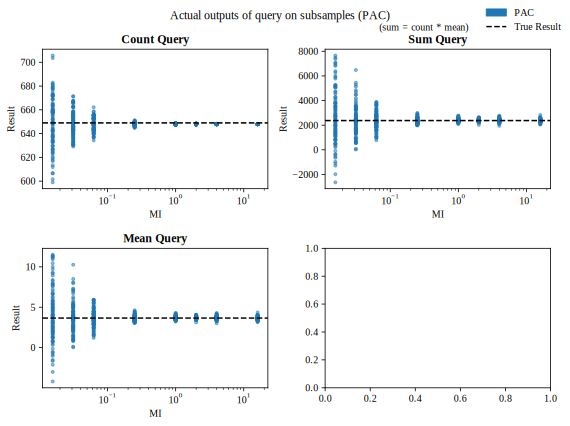

In [29]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log')
    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

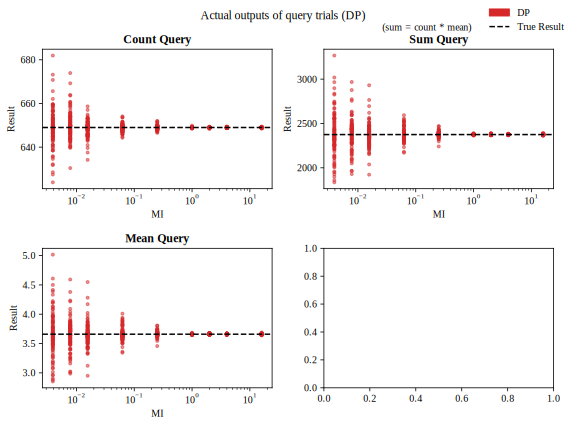

In [30]:
### Plotting the actual experiment outputs used (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'dp'

    ax.scatter(dp_results_df['mi'], dp_results_df[query], label=query, marker='.', alpha=0.5, color=DP_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    ax.set_xscale('log')
    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp.jpg", bbox_inches='tight')
plt.show()

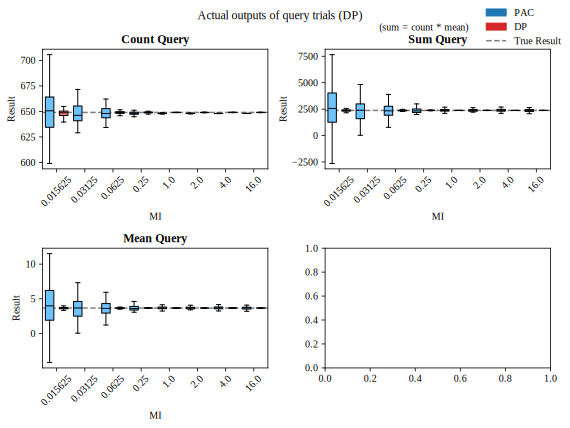

In [31]:
### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.linewidth = 0.25

    # correct answer
    ax.axhline(y=true_result[i], color='gray', linestyle='--', label='True Result')

    for mi in MI_OPTIONS: # categorical variable
        position = MI_OPTIONS.index(mi) * 2

        TYPE = 'pac'

        pac_style = {
            'boxprops': dict(facecolor=PAC_LIGHT),
            'medianprops': dict(color='black')
        }
        
        # mi = mi and query is correct
        d = df[df['mi'] == mi][['mi', query]].iloc[:, 1].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **pac_style)

        position += 1
        TYPE = 'dp'

        dp_style = {
            'boxprops': dict(facecolor=DP_LIGHT),
            'medianprops': dict(color='black')
        }

        # mi = mi and query is correct
        d = dp_results_df[dp_results_df['mi'] == mi][['mi', query]].iloc[:, 1].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **dp_style)
    
    
    
    # override xticks, one for each pair of boxplots
    ax.set_xticks([0.5+2*i for i in range(len(MI_OPTIONS))])
    ax.set_xticklabels(MI_OPTIONS, rotation=45)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='gray', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp_vs_pac.jpg", bbox_inches='tight')
plt.show()
